# FIne Tuning: Spam Detection

## Messages Dataset

In [3]:
import urllib.request
import zipfile
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
from pathlib import Path
import tiktoken

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
file_path = Path("sms_spam_collection.zip")
extracted_path = Path("sms_spam_collection")
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def downlaod_and_unzip_spam_dataset(url, zip_path, extracted_path, data_file_path   ):  
    if not zip_path.exists():
        urllib.request.urlretrieve(url, zip_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"

    if not data_file_path.exists():
        with zipfile.ZipFile(file_path, "r") as zip_ref:
            zip_ref.extractall(extracted_path)

    os.rename(original_file_path, data_file_path.with_name("SMSSpamCollection.tsv"))
    print(f"Dataset downloaded and unzipped to {data_file_path}")

downlaod_and_unzip_spam_dataset(url, file_path, extracted_path, data_file_path)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'sms_spam_collection\\SMSSpamCollection' -> 'sms_spam_collection\\SMSSpamCollection.tsv'

In [5]:
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

print(df["Label"].value_counts())
df

Label
ham     4825
spam     747
Name: count, dtype: int64


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
def create_balanced_dataset(df):
    # Count the number of spam and ham messages
    spam_count = df[df['Label'] == 'spam'].shape[0]
    ham_count = df[df['Label'] == 'ham'].shape[0]
    
    # Calculate the number of samples to keep for each class
    min_samples = min(spam_count, ham_count)
    # Randomly sample the dataset to balance the classes
    balanced_df = pd.concat([
        df[df['Label'] == 'spam'].sample(min_samples),
        df[df['Label'] == 'ham'].sample(min_samples)
    ])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

balanced_df


Label
spam    747
ham     747
Name: count, dtype: int64


,Label,Text
357,1,Congratulations ur awarded 500 of CD vouchers ...
1915,1,New TEXTBUDDY Chat 2 horny guys in ur area 4 j...
2910,1,URGENT! Your Mobile number has been awarded wi...
3014,1,FREE UNLIMITED HARDCORE PORN direct 2 your mob...
591,1,For ur chance to win a £250 wkly shopping spre...
...,...,...
1201,0,Otherwise had part time job na-tuition..
4306,0,Yo come over carlos will be here soon
3827,0,"Goodmorning,my grandfather expired..so am on l..."
3565,0,Do you always celebrate NY's with your family ?


In [7]:
def random_split(df, train_frac, validation_frac):

    df = df.sample(frac=1,random_state=123).reset_index(drop=True)

    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=False)
validation_df.to_csv("validation.csv", index=False)
test_df.to_csv("test.csv", index=False)



In [8]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_len=None, padding_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_Texts = [
            tokenizer.encode(text)
            for text in self.data["Text"]
        ]

        if max_len is None:
            self.max_len = self._longest_encoded_length()
        else:
            self.max_len = max_len

            self.encoded_Texts = [
                encoded_Text[:self.max_len]
                for encoded_Text in self.encoded_Texts
            ]

        self.encoded_Texts = [
            encoded_Text + [padding_token_id] * (self.max_len - len(encoded_Text))
            for encoded_Text in self.encoded_Texts
        ]
        

    def _longest_encoded_length(self):
        return max(len(encoded_Text) for encoded_Text in self.encoded_Texts)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        encoded = self.encoded_Texts[idx]
        Label = self.data.iloc[idx]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(Label, dtype=torch.long)
        )

In [9]:
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset("train.csv", tokenizer, max_len=None)

print(train_dataset.max_len)
validation_dataset = SpamDataset("validation.csv", tokenizer, max_len=train_dataset.max_len)
test_dataset = SpamDataset("test.csv", tokenizer, max_len=train_dataset.max_len)


120


In [10]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [11]:
for input_batch, target_batch in train_loader:
    pass

print(input_batch.shape)
print(target_batch.shape)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))


torch.Size([8, 120])
torch.Size([8])
130
19
38


# Loading the model

In [12]:
CHOSEN_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}

model_configs = {
    "gpt2-small (124M)": {
        "emb_dim": 768,
        "n_layers": 12,
        "n_heads": 12,
    },
    "gpt2-medium (355M)": {
        "emb_dim": 1024,
        "n_layers": 24,
        "n_heads": 16,
    },
    "gpt2-large (774M)": {
        "emb_dim": 1280,
        "n_layers": 36,
        "n_heads": 20,
    },
    "gpt2-xl (1558M)": {
        "emb_dim": 1600,  
        "n_layers": 48,
        "n_heads": 24,
    }
}

BASE_CONFIG.update(model_configs[CHOSEN_MODEL])

In [13]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOSEN_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)

load_weights_into_gpt(model, params)

model.eval()


File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [14]:
from previous_chapters import generate_text_simple, text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model,
    idx = text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))


text_2 = (
    "Is the following text spam? answer with 'yes' or 'no'"
    " 'You are a winner you have specifically"
    " selected to receive a 1000 dollar prize' "
)

token_ids = generate_text_simple(
    model,
    idx = text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))


Every effort moves you forward.

The first step is to understand the importance of your work
Is the following text spam? answer with 'yes' or 'no' 'You are a winner you have specifically selected to receive a 1000 dollar prize'  or 'you have selected to receive a 1000 dollar prize'  or 'you have selected to receive a


# Modifying the model for fine tuning

In [15]:
for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)
num_classes = 2

model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes,
)

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True
for param in model.out_head.parameters(): #should be true anyway by default but regardless
    param.requires_grad = True

In [16]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print(inputs)
print(inputs.shape)

with torch.no_grad():
    outputs = model(inputs)

print(outputs)
print(outputs.shape)

print("Last output token", outputs[:, -1, :])

logits = outputs[:, -1, :]
label = torch.argmax(logits)

print("Predicted label", label.item())


tensor([[5211,  345,  423,  640]])
torch.Size([1, 4])
tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
torch.Size([1, 4, 2])
Last output token tensor([[-3.5983,  3.9902]])
Predicted label 1


In [17]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()

    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            
            predicted_labels = torch.argmax(logits, dim=1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += ((predicted_labels == target_batch).sum().item())

        else:
            break
    return correct_predictions / num_examples

def calc_loss_batch(input_batch, target_batch, model, device):

    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)[:, -1, :]   
    loss = torch.nn.functional.cross_entropy(logits, target_batch)

    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):   
        if i < num_batches: 
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Train accuracy: {train_accuracy*100:.4f}%")
print(f"Validation accuracy: {val_accuracy*100:.4f}%")
print(f"Test accuracy: {test_accuracy*100:.4f}%")

Train accuracy: 53.7500%
Validation accuracy: 55.0000%
Test accuracy: 51.2500%


In [19]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Train loss: {train_loss:.4f}")
print(f"Validation loss: {val_loss:.4f}")
print(f"Test loss: {test_loss:.4f}")


Train loss: 2.6990
Validation loss: 2.5840
Test loss: 2.8429


In [21]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()
    return train_loss, val_loss

def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range (num_epochs):
        model.train()

        for input_batch, target_batch, in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(
                    f"Ep {epoch+1} (step: {global_step:06d})"
                    f"Train loss {train_loss:.3f}"
                    f"Val loss {val_loss:.3f}"
                )

            train_accuracy = calc_accuracy_loader(
                train_loader, model, device, num_batches=eval_iter)
            
            val_accuracy = calc_accuracy_loader(
                val_loader, model, device, num_batches=eval_iter)
            
            print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
            print(f"Validation accuracy: {val_accuracy*100:.2f}%")
            train_accs.append(train_accuracy)
            val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen
    

In [22]:
import time
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()

print(f"Total training time: {end_time - start_time:.2f} seconds")

Ep 1 (step: 000000)Train loss 2.634Val loss 2.394
Training accuracy: 50.00% | Validation accuracy: 50.00%
Training accuracy: 37.50% | Validation accuracy: 50.00%
Training accuracy: 50.00% | Validation accuracy: 50.00%
Training accuracy: 65.00% | Validation accuracy: 50.00%
Training accuracy: 55.00% | Validation accuracy: 50.00%
Training accuracy: 42.50% | Validation accuracy: 50.00%
Training accuracy: 52.50% | Validation accuracy: 50.00%
Training accuracy: 52.50% | Validation accuracy: 50.00%
Training accuracy: 47.50% | Validation accuracy: 50.00%
Training accuracy: 65.00% | Validation accuracy: 50.00%
Training accuracy: 60.00% | Validation accuracy: 50.00%
Training accuracy: 52.50% | Validation accuracy: 47.50%
Training accuracy: 70.00% | Validation accuracy: 50.00%
Training accuracy: 45.00% | Validation accuracy: 50.00%
Training accuracy: 50.00% | Validation accuracy: 50.00%
Training accuracy: 50.00% | Validation accuracy: 50.00%
Training accuracy: 45.00% | Validation accuracy: 50.00

# Now let's plot the loss

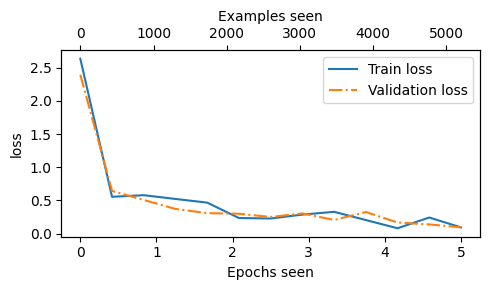

In [23]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values, label="loss"):
    
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Train {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")

    ax1.set_xlabel("Epochs seen")
    ax1.set_ylabel(label)
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

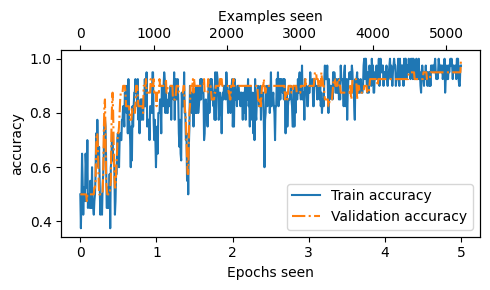

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [26]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Train accuracy: 95.96%
Validation accuracy: 94.63%
Test accuracy: 95.67%


# Now to use the model

In [28]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]

    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"


In [34]:
text1 = (
    "You have won a coupon, but you must redeem now"
)

print(classify_review(text1, model, tokenizer, device, max_length=train_dataset.max_len))

text2 = (
    "I'm going to the movies tonight"
)

print(classify_review(text2, model, tokenizer, device, train_dataset.max_len))


not spam
not spam


In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")

model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)


